Accuracy: 1.00
Classification Report:
                precision    recall  f1-score   support

   0    0    0       1.00      1.00      1.00       186
   0    0  195       1.00      1.00      1.00       172
   0  225    0       1.00      1.00      1.00       158
   0  225  195       1.00      1.00      1.00       162
 255    0    0       1.00      1.00      1.00       177
 255    0  195       1.00      1.00      1.00       158
 255  225    0       1.00      1.00      1.00       168
 255  225  195       1.00      1.00      1.00       159

      accuracy                           1.00      1340
     macro avg       1.00      1.00      1.00      1340
  weighted avg       1.00      1.00      1.00      1340



/home/cas/work/Projects/ML_predict_target_board_RGB_LED_state-ESP32-S3_CircuitPython/03_pc_linux_software/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


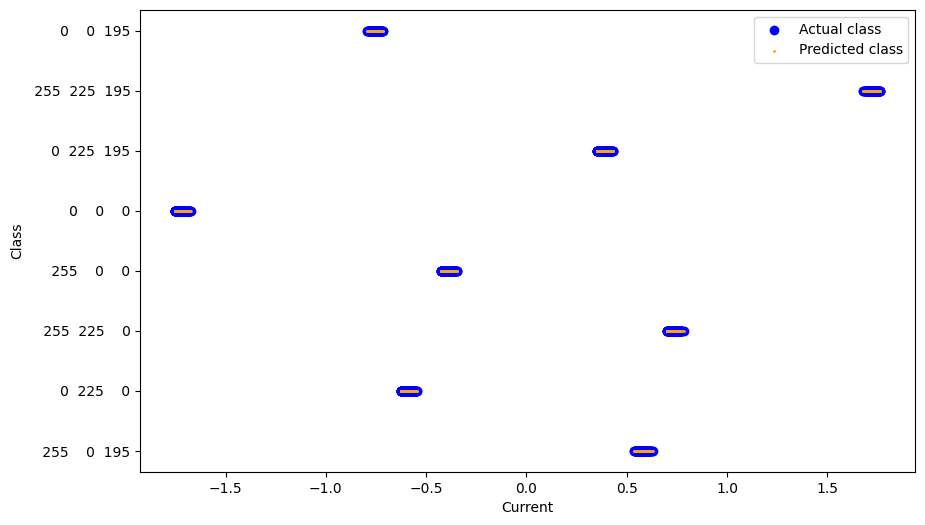

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Read the data file
df = pd.read_csv("./labeled_dataset_2024.05.24-03h39m42s-rgb_combinations_labeled_ordered.csv", sep=',')

# Create separate lists for current and RGB values
x = df[['current']].values.reshape(-1, 1)
y = df['   R    G    B']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the MLPClassifier with one hidden layer of 5 neurons
mlp = MLPClassifier(hidden_layer_sizes=(5,), max_iter=200, random_state=42)

# Train the model
mlp.fit(X_train, y_train)

# Make predictions on the test set
y_pred = mlp.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Create a scatter plot for the actual and predicted classes
plt.figure(figsize=(10, 6))

plt.scatter(X_test, y_test, label='Actual class', color='blue')
plt.scatter(X_test, y_pred, label='Predicted class', color='orange', s=1)
plt.xlabel('Current')
plt.ylabel('Class')
plt.legend()

plt.show()


Accuracy: 0.86
Classification Report:
                precision    recall  f1-score   support

   0    0    0       0.00      0.00      0.00       186
   0    0  195       0.48      1.00      0.65       172
   0  225    0       1.00      1.00      1.00       158
   0  225  195       1.00      1.00      1.00       162
 255    0    0       1.00      1.00      1.00       177
 255    0  195       1.00      1.00      1.00       158
 255  225    0       1.00      1.00      1.00       168
 255  225  195       1.00      1.00      1.00       159

      accuracy                           0.86      1340
     macro avg       0.81      0.88      0.83      1340
  weighted avg       0.79      0.86      0.82      1340



/home/cas/work/Projects/ML_predict_target_board_RGB_LED_state-ESP32-S3_CircuitPython/03_pc_linux_software/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cas/work/Projects/ML_predict_target_board_RGB_LED_state-ESP32-S3_CircuitPython/03_pc_linux_software/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cas/work/Projects/ML_predict_target_board_RGB_LED_state-ESP32-S3_CircuitPython/03_pc_linux_software/venv/lib/python3.12/site-packages/sklearn/metrics/_classific

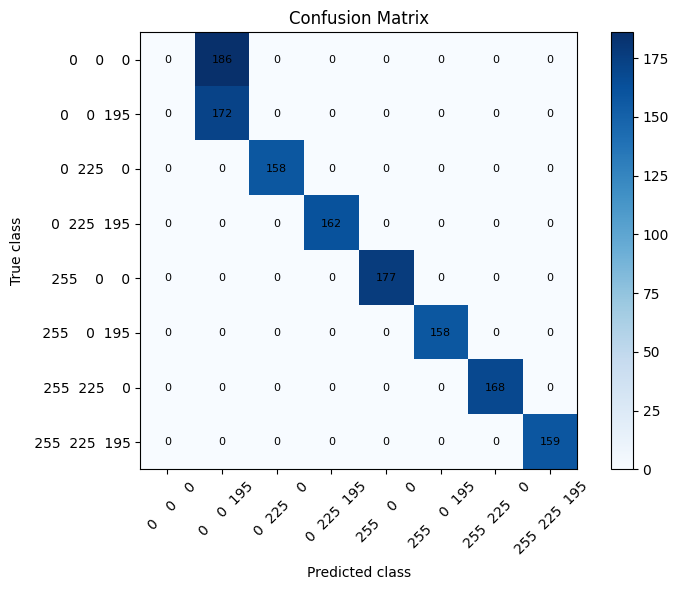

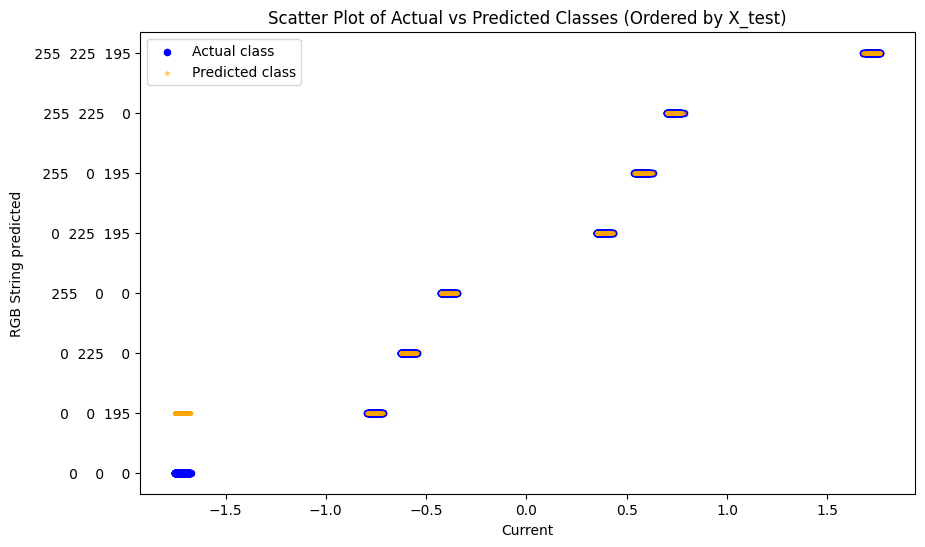

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Read the data file
df = pd.read_csv("./labeled_dataset_2024.05.24-03h39m42s-rgb_combinations_labeled_ordered.csv", sep=',')

# Create separate lists for current and RGB values
x = df[['current']].values.reshape(-1, 1)
y = df['   R    G    B']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the MLPClassifier with one hidden layer and set the number of classes as the output layer size
mlp = MLPClassifier(hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver='lbfgs', activation='relu')

# Train the model
mlp.fit(X_train, y_train)
X_test
# Make predictions on the test set
y_pred = mlp.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))

# Add labels and title
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion Matrix')

# Add text with counts on confusion matrix
for i in range(len(cm)):
    for j in range(len(cm[i])):
        plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# Create a list of tuples to combine data and sorting key
data_list = list(zip(X_test, y_test, y_pred))
sorted_data = sorted(data_list, key=lambda x: x[0])  # Sort by first element (x_data)

# Unpack the sorted data
X_test, y_test, y_pred = zip(*sorted_data)

# Scatter plot for actual and predicted values
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, s=20, label='Actual class', color='blue')
plt.scatter(X_test, y_pred, s=5, label='Predicted class', color='orange', alpha=0.5)
plt.xlabel('Current')
plt.ylabel('RGB String predicted')
plt.title('Scatter Plot of Actual vs Predicted Classes (Ordered by X_test)')
plt.legend()
plt.show()

import pickle

# Save the classifier
with open('classifier_nn.pkl', 'wb') as f:
    pickle.dump(mlp, f)

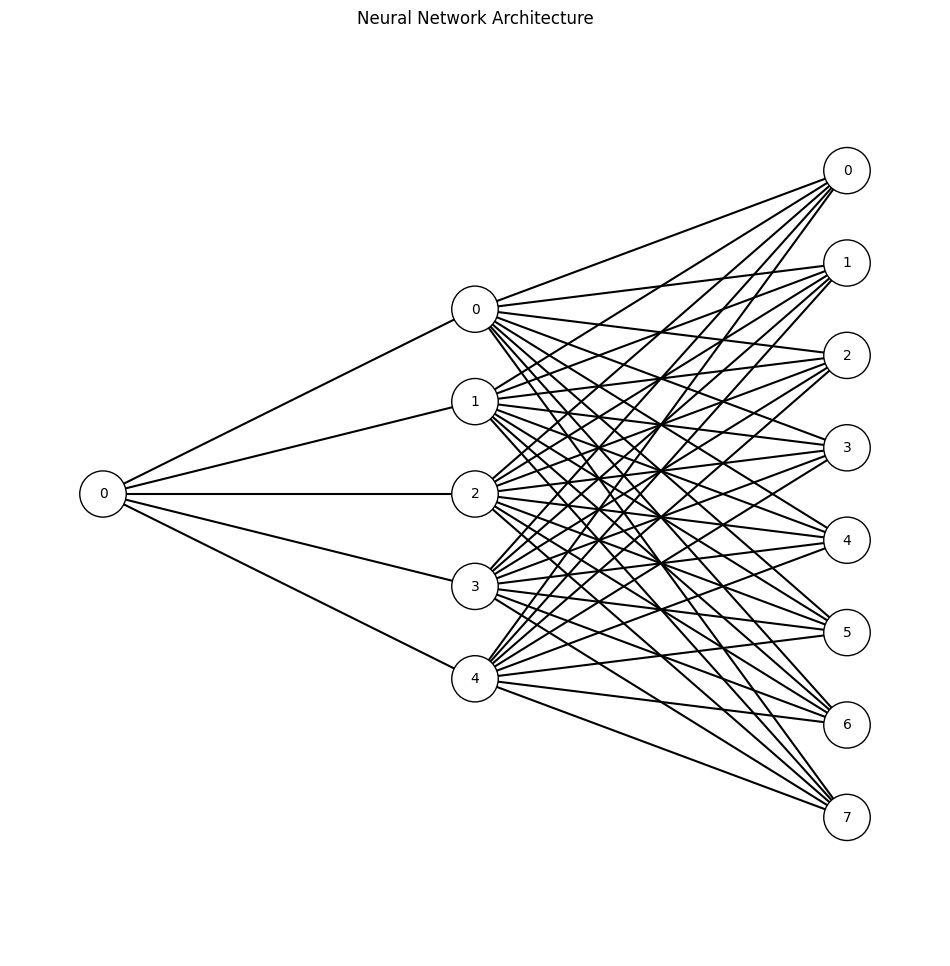

In [23]:
import matplotlib.pyplot as plt
import networkx as nx
import pickle
from sklearn.neural_network import MLPClassifier

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotlib.
    
    :param ax: matplotlib.axes.Axes, the axes on which to plot the cartoon (get e.g. by plt.gca())
    :param left: float, the center of the leftmost node(s) will be placed here
    :param right: float, the center of the rightmost node(s) will be placed here
    :param bottom: float, the center of the bottommost node(s) will be placed here
    :param top: float, the center of the topmost node(s) will be placed here
    :param layer_sizes: list of int, list containing the number of nodes in each layer
    '''
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)

    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
            # Annotation for nodes
            ax.text(n*h_spacing + left, layer_top - m*v_spacing, '{}'.format(m), ha='center', va='center', zorder=5)

    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

# Load the classifier
with open('classifier_nn.pkl', 'rb') as f:
    clf = pickle.load(f)

# Define the architecture of the network
if isinstance(clf.hidden_layer_sizes, int):
    layer_sizes = [clf.n_features_in_] + [clf.hidden_layer_sizes] + [clf.n_outputs_]
else:
    layer_sizes = [clf.n_features_in_] + list(clf.hidden_layer_sizes) + [clf.n_outputs_]

# Plot the neural network
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, layer_sizes)
plt.title('Neural Network Architecture')
plt.show()


In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Read the data file
df = pd.read_csv("./labeled_dataset_2024.05.24-03h39m42s-rgb_combinations_labeled.csv", sep=',')
df = df.sort_values(by='current')

# Create separate lists for current and RGB values
x = df['current']
y = df['rgb unique combination']

for x_,y_ in zip(x.head(5),y.head(5)):
  print(x_,y_)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Standardize the features (important for neural networks)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

class NeuralNetwork:
  def __init__(self, input_size, hidden_size, output_size, learning_rate):
    self.weights1 = np.random.rand(input_size, hidden_size)
    self.weights2 = np.random.rand(hidden_size, output_size)
    self.bias1 = np.zeros((1, hidden_size))
    self.bias2 = np.zeros((1, output_size))
    self.learning_rate = learning_rate

  def relu(self, x):
    """ReLU (Rectified Linear Unit) activation function."""
    return np.maximum(0, x)

  def predict(self, X):
    # Forward propagation
    hidden_layer = self.relu(np.dot(X, self.weights1) + self.bias1)
    output = self.relu(np.dot(hidden_layer, self.weights2) + self.bias2)
    return output

  def train(self, X, y, epochs):
    for epoch in range(epochs):
      # Forward propagation
      hidden_layer = self.relu(np.dot(X, self.weights1) + self.bias1)
      output = self.relu(np.dot(hidden_layer, self.weights2) + self.bias2)
      output = output.reshape(-1)  # Reshape output to 1D

      # Calculate errors
      output_error = y - output
      hidden_error = np.dot(output_error, self.weights2.T) * hidden_layer * (1 - hidden_layer)

      # Backpropagation
      self.weights2 -= self.learning_rate * np.dot(hidden_layer.T, output_error)
      self.bias2 -= self.learning_rate * output_error.sum(axis=0, keepdims=True)
      self.weights1 -= self.learning_rate * np.dot(X.T, hidden_error)
      self.bias1 -= self.learning_rate * hidden_error.sum(axis=0, keepdims=True)

# Define and train your model
model = NeuralNetwork(1, 4, 1, 0.01)
model.train(X_train, y_train, 100)

# Print the weights and biases after training
print("Weights1:", model.weights1)
print("Weights2:", model.weights2)
print("Bias1:", model.bias1)
print("Bias2:", model.bias2)

0.068708 5
0.068708 5
0.068708 5
0.068708 5
0.068732 5


ValueError: shapes (5360,) and (1,4) not aligned: 5360 (dim 0) != 1 (dim 0)